In [ ]:
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd

In [26]:
%cd /content/Machine_learning_for_flood_susceptibility


/content/Machine_learning_for_flood_susceptibility


In [27]:
!git pull origin main

remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), 2.64 KiB | 676.00 KiB/s, done.
From https://github.com/xahid007/Machine_learning_for_flood_susceptibility
 * branch            main       -> FETCH_HEAD
   0597952..8e28000  main       -> origin/main
Updating 0597952..8e28000
Fast-forward
 point-based models/Output_1/points_data.cpg     |   1 +
 point-based models/Output_1/points_data.dbf     | Bin 0 -> 18646 bytes
 point-based models/Output_1/points_data.shp     | Bin 0 -> 3124 bytes
 point-based models/Output_1/points_data.shx     | Bin 0 -> 772 bytes
 point-based models/output from Data Preparation |   1 +
 5 files changed, 2 insertions(+)
 create mode 100644 point-based models/Output_1/points_data.cpg
 create mode 100644 point-based models/Output_1/points_data.dbf
 create mode 100644 point-based models/Output_

In [28]:
# Read the shapefile or pickle which we created in last article
df=gpd.read_file("/content/Machine_learning_for_flood_susceptibility/point-based models/Output_1/points_data.shp")
# df=pd.read_pickle("points_data.pkl") # in case of pickle
df.head()

,Label,DEM,Slope,Aspect,Curvature,TWI,DTDrainage,DTRoad,DTRiver,CN,AP,FP,geometry
0,0,0,0,0,0,0,0,0,0,0,0,0,POINT Z (382328.441 5814043.781 0.000)
1,0,0,0,0,0,0,0,0,0,0,0,0,POINT Z (382580.854 5814097.359 0.000)
2,0,0,0,0,0,0,0,0,0,0,0,0,POINT Z (382758.655 5814802.211 0.000)
3,0,0,0,0,0,0,0,0,0,0,0,0,POINT Z (382782.361 5815220.465 0.000)
4,0,0,0,0,0,0,0,0,0,0,0,0,POINT Z (382814.111 5816035.383 0.000)


In [29]:
#check that there is no no data values in the dataset
print(df.isnull().sum())
#df = df.dropna() # use this to remove rows with no data values

Label         0
DEM           0
Slope         0
Aspect        0
Curvature     0
TWI           0
DTDrainage    0
DTRoad        0
DTRiver       0
CN            0
AP            0
FP            0
geometry      0
dtype: int64


<Axes: xlabel='Label', ylabel='count'>

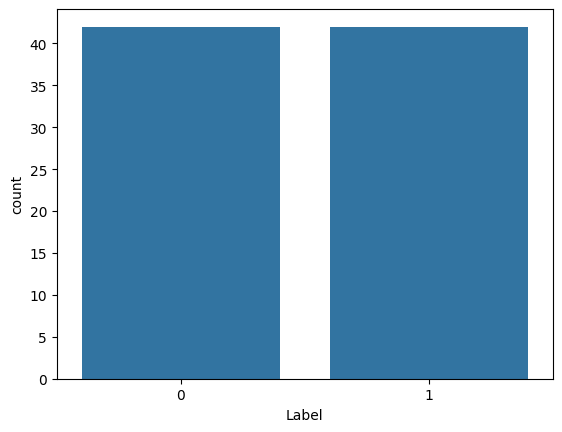

In [30]:
#Understand the data
#Here we can see that we have a balanced dataset (equal number of flooded and non flooeded locations
sns.countplot(x="Label", data=df) #0 - Notflooded   1 - Flooded

<ipython-input-38-468618ce58ec>:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = df.corr()


<Axes: >

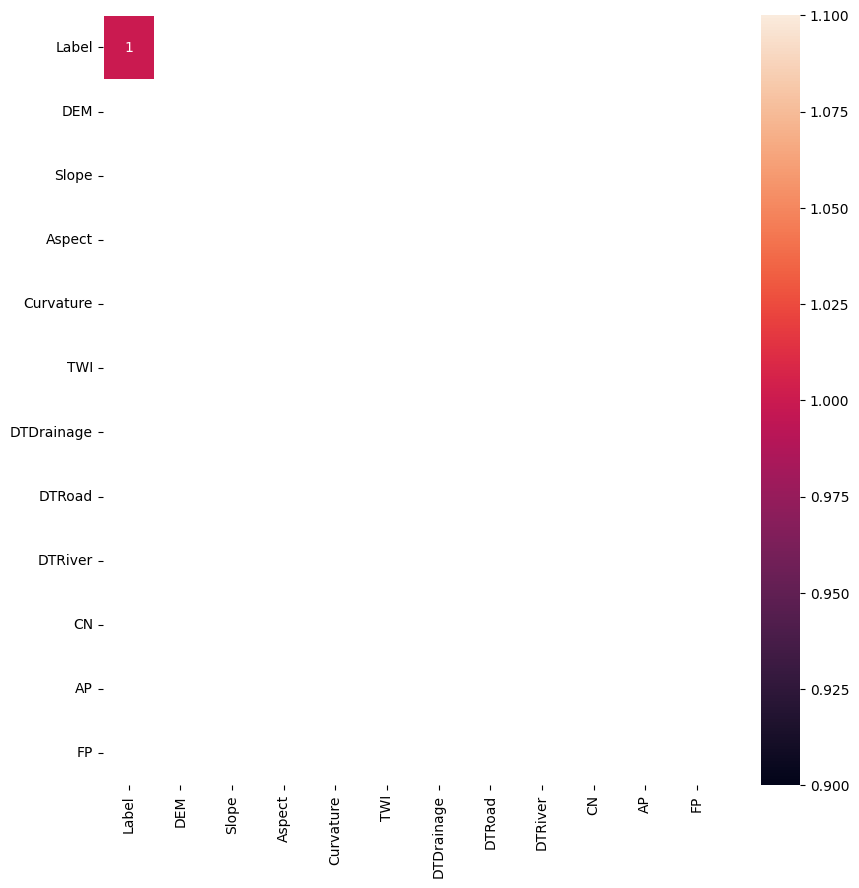

In [38]:
# show the correlation matric for the dataset
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

In [39]:
#Define the dependent variable that needs to be predicted (labels)
Y = df["Label"].values

#Define the independent variables. Let's also drop gemotry and label
X = df.drop(labels = ["Label", "geometry"], axis=1)
features_list = list(X.columns)  #List features so we can rank their importance later

In [40]:
#Split data into train (60 %), validate (20 %) and test (20%) to verify accuracy after fitting the model.
# training data is used to train the model
# validation data is used for hyperparameter tuning
# testing data is used to test the model

from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2,shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,shuffle=True, random_state=42)

In [42]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42) # I am using the default values of the parameters.

# Train the model on training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
# make prediction for the test dataset.
prediction = model.predict(X_test)

# The prediction values are either 1 (Flooded) or 0 (Non-Flooded)
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
# The AUC is considered one of the best performance indices
# We can plot the curve and calculate it
from sklearn.metrics import plot_roc_curve

ax = plt.gca()
model_disp = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (/usr/local/lib/python3.10/dist-packages/sklearn/metrics/__init__.py)

## Map the whole study area

In [53]:
# Read shapefile for the whole study area
df_SA=gpd.read_file("Study_area.shp")
df_SA.head() # make sure that the dataset has the same column arrangement as the training dataset



ERROR:fiona._env:Study_area.shp: No such file or directory


DriverError: Study_area.shp: No such file or directory

In [ ]:
X_SA= df_SA.drop(labels = ["geometry"], axis=1) # we need to remove all the columns except the predictive features
X_SA.head()


In [ ]:
prediction_SA = model.predict(X_SA) # predict if the location is flooded (1) or not flooded (0)



In [ ]:
# In order to map the flood susceptibility we need to cacluate the probability of being flooded
prediction_prob=model.predict_proba(X_SA) # This function return an array with lists
# each list has two values [probability of being not flooded , probability of being flooded]

# We need only the probablity of being flooded
# We need to add the value coressponding to each point

df_SA['FSM']= prediction_prob[:,1]

In [ ]:
# Save the dataframe tp a shapefile in case of converting the points to raster using QGIS or Arcmap
df_SA.to_file("FSM.shp")

In [ ]:
# Converting the point shapefile to raster.
# We will use the model prediction (column FSM in df_SA to make a raster)
from geocube.api.core import make_geocube
import rasterio as rio

out_grid= make_geocube(vector_data=df_SA, measurements=["FSM"], resolution=(-1, 1)) #for most crs negative comes first in resolution
out_grid["FSM"].rio.to_raster("Flood_susceptibility.tif")